### Readme
notebook que carga y analiza el fichero JSON con información de repositorios
los datos se han obtenido via API GraphQL y REST API de github

### Carga de librerías y fichero de datos. comprobaciones básicas

In [1]:
# imports de librerías requeridas

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import json
from tabulate import tabulate
import locale

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.stats import randint


In [2]:
#pd.set_option('display.precision', 2)  # Configurar la precisión de decimales

# Configurar la visualización para que los números se muestren en formato europeo
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x).replace(',', 'X').replace('.', ',').replace('X', '.'))

In [3]:
DATA_FILE='D:\\Dev\\github-scrapping-02\\Data\\df_clean.json'
NEW_DATA_FILE='D:\\Dev\\github-scrapping-02\\Data\\df_new_records.json'

# Fichero df_clean.sjon contenia fechas en formato UNIX seconds. Se convirtió a DateTime de nuevo en el siguiente fichero
#DATA_FILE='D:\\Dev\\github-scrapping-02\\Data\\df_clean_w_correct_date.json'

In [4]:
# Leer el archivo JSON y convertir las columnas de fecha
df = pd.read_json(DATA_FILE, orient='records', lines=True, convert_dates=['createdAt', 'pushedAt', 'updatedAt'])
df_new=pd.read_json(NEW_DATA_FILE, orient='records', lines=True, convert_dates=['createdAt', 'pushedAt', 'updatedAt'])


In [5]:
df_copy=df.copy()

In [6]:
# Definición de las columnas numéricas y categóricas según la estructura de df_copy
# son las varialbes seleccionadas en E3

columnas_numericas = [
    'assignableUsers',
    'contributors',
    'deployments',
    'diskUsage',
    'environments',
    'milestones',
    'releases',
    'language_count'
]

# Definición de columnas categóricas
columnas_categoricas = [
    'hasIssuesEnabled',
    'hasProjectsEnabled',
    'hasSponsorshipsEnabled',
    'hasWikiEnabled',
    'isInOrganization',
    'isTemplate'
]

lennum=len(columnas_numericas)
lencat=len(columnas_categoricas)
# Mostrar los resultados
print("Columnas Numéricas:")
print(lennum, columnas_numericas)
print("\nColumnas Categóricas:")
print(lencat, columnas_categoricas)
print("total: ",lennum+lencat)
columns_to_cluster=columnas_numericas+columnas_categoricas

Columnas Numéricas:
8 ['assignableUsers', 'contributors', 'deployments', 'diskUsage', 'environments', 'milestones', 'releases', 'language_count']

Columnas Categóricas:
6 ['hasIssuesEnabled', 'hasProjectsEnabled', 'hasSponsorshipsEnabled', 'hasWikiEnabled', 'isInOrganization', 'isTemplate']
total:  14


In [7]:
# convertir boolean a numero

# Crear una copia del dataframe
df_copy_converted_boolean = df_copy.copy()

# Transformar booleanos en números (0 y 1)
df_copy_converted_boolean[columnas_categoricas] = df_copy_converted_boolean[columnas_categoricas].astype(int)

# Verificar la transformación
df_copy_converted_boolean[columns_to_cluster].head()

,assignableUsers,contributors,deployments,diskUsage,environments,milestones,releases,language_count,hasIssuesEnabled,hasProjectsEnabled,hasSponsorshipsEnabled,hasWikiEnabled,isInOrganization,isTemplate
0,4,22,0,55148,0,0,26,5,1,1,0,1,1,0
1,1,15,0,9068,0,0,4,2,1,1,1,1,0,0
2,4,4,0,548,0,0,4,2,1,1,0,1,1,0
3,1,11,100,310,2,0,1,2,1,1,1,1,1,0
4,1,10,0,8118,0,0,0,4,1,1,0,0,0,0


In [8]:
# idem para nuevos registros

# Crear una copia del dataframe
df_new_converted_boolean = df_new.copy()

# Transformar booleanos en números (0 y 1)
df_new_converted_boolean[columnas_categoricas] = df_new_converted_boolean[columnas_categoricas].astype(int)

# Verificar la transformación
df_new_converted_boolean[columns_to_cluster].head()

,assignableUsers,contributors,deployments,diskUsage,environments,milestones,releases,language_count,hasIssuesEnabled,hasProjectsEnabled,hasSponsorshipsEnabled,hasWikiEnabled,isInOrganization,isTemplate
0,3,3,0,8432,0,0,0,6,1,1,0,1,1,0
1,6,69,0,169293,0,0,18,3,1,1,0,1,1,0
2,1,8,0,717,0,0,4,2,1,0,0,0,0,0
3,1,1,29,2135,1,0,0,5,1,1,1,1,0,0
4,1,15,0,8277,0,0,0,6,1,1,0,1,1,0


In [9]:
# outliers
def eliminar_outliers(df, columns):
    df_clean = df.copy()
    LIM=3
    for col in columns:
        if pd.api.types.is_numeric_dtype(df_clean[col]):
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - LIM * IQR
            upper_bound = Q3 + LIM * IQR
            df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

In [10]:
# Eliminar outliers
df_clean = eliminar_outliers(df_copy_converted_boolean, columns_to_cluster)

# Mostrar el tamaño del DataFrame limpio
print(f'Tamaño original: {df_copy.shape[0]}, Tamaño después de eliminar outliers: {df_clean.shape[0]}')

Tamaño original: 37120, Tamaño después de eliminar outliers: 12290


In [11]:
# Eliminar outliers de los datos nuevos
df_new_filtered = eliminar_outliers(df_new_converted_boolean, columns_to_cluster)

# Mostrar el tamaño del DataFrame limpio
print(f'Tamaño original: {df_new.shape[0]}, Tamaño después de eliminar outliers: {df_new_filtered.shape[0]}')

Tamaño original: 5040, Tamaño después de eliminar outliers: 1731


## Segmentación, definir función de caracterización y comparar nuevos con viejos

In [14]:
# segmentación
O=['assignableUsers', 'contributors', 'isInOrganization']
P=['deployments', 'isTemplate', 'environments', 'hasIssuesEnabled', 'hasProjectsEnabled', 'hasSponsorshipsEnabled', 'hasWikiEnabled', 'milestones']
A=['diskUsage', 'releases', 'language_count']
AOP=A+O+P

In [103]:
# Generar datos sintéticos a partir de los stats de los originales

# Crear una copia del DataFrame original para trabajar con ella
df_temp = df_copy.copy()

# Definir el número de registros sintéticos a generar
n_registros_sinteticos = df_clean.shape[0]

# Listar todas las variables numéricas de AOP
variables_numericas = ['diskUsage', 'releases', 'language_count', 
                        'assignableUsers', 'contributors', 
                        'deployments', 'environments', 
                        'milestones']

# Obtener los estadísticos de las variables numéricas
stats_numericas = df_temp[variables_numericas].describe().T[['25%', '50%', '75%']].to_dict('index')

# Inicializar un diccionario para almacenar los límites inferior y superior para outliers
outlier_limits = {}

# Calcular los límites para los outliers utilizando el IQR
for var, stats in stats_numericas.items():
    Q1 = stats['25%']
    Q3 = stats['75%']
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_limits[var] = (lower_bound, upper_bound)

# Identificar las columnas booleanas
boolean_columns = ['hasIssuesEnabled', 'hasProjectsEnabled', 'hasSponsorshipsEnabled', 
                   'hasWikiEnabled', 'isInOrganization', 'isTemplate']

# Inicializar un diccionario para almacenar las frecuencias relativas de las variables booleanas
frecuencias_booleans = {}

# Calcular las frecuencias relativas de las columnas booleanas
for column in boolean_columns:
    total = df_temp[column].count()
    true_count = df_temp[column].sum()
    false_count = total - true_count
    frecuencias_booleans[column] = {
        'True': true_count / total,
        'False': false_count / total
    }

# Crear un DataFrame vacío para los registros sintéticos
df_sinteticos = pd.DataFrame()

# Generar registros sintéticos para variables numéricas
for var, stats in stats_numericas.items():
    # Calcular el límite inferior y superior para outliers
    lower_bound, upper_bound = outlier_limits[var]
    
    # Evitar log(0) ajustando el valor de la mediana si es cero
    mediana = stats['50%']
    if mediana <= 0:
        mediana = 0.01  # Usar un pequeño valor positivo

    # Generar valores en una distribución log-normal
    values = np.random.lognormal(mean=np.log(mediana), sigma=stats['75%'] - stats['25%'], size=n_registros_sinteticos)
    
    # Aplicar límites para evitar outliers graves
    df_sinteticos[var] = np.clip(values, lower_bound, upper_bound)

# Generar registros sintéticos para variables booleanas
for var, freqs in frecuencias_booleans.items():
    df_sinteticos[var] = np.random.choice(
        [True, False], 
        size=n_registros_sinteticos, 
        p=[freqs['True'], freqs['False']]
    )

# Validar que los valores generados se encuentran dentro de los rangos esperados
#for var in variables_numericas:
#    print(f"Valores generados para {var}:")
#    print(df_sinteticos[var].describe())  # Imprimir descripción para validar valores

# Imprimir los primeros registros sintéticos
# print(df_sinteticos.head())


### función de cáclulo de coeficientes APO

In [58]:
# Definir funciones de cáclulo de coeficientes AOP

from sklearn.preprocessing import RobustScaler

# Definir los pesos para cada grupo de variables
weights = {
    'O': 0.5,  # Peso para el grupo O
    'P': 0.3,  # Peso para el grupo P
    'A': 0.2   # Peso para el grupo A
}

def calcular_coeficiente_sinteticos(df, O, P, A, weights):
    # coeficiente normalziado entre [0,1]
    # Inicializar el scaler
    scaler = RobustScaler()

    # Normalizar las variables de cada grupo utilizando RobustScaler.
    df[O] = scaler.fit_transform(df[O])
    df[P] = scaler.fit_transform(df[P])
    df[A] = scaler.fit_transform(df[A])
    
    # Sumar los valores ponderados para calcular el coeficiente de esfuerzo.
    coeficiente = (weights['O'] * df[O].sum(axis=1) + 
                   weights['P'] * df[P].sum(axis=1) + 
                   weights['A'] * df[A].sum(axis=1))
    
    # Asegurarse de que no haya valores negativos
    coeficiente = np.clip(coeficiente, a_min=0, a_max=None)  
    
    # Normalizar el coeficiente para que esté entre 0 y 1
    coeficiente = (coeficiente - coeficiente.min()) / (coeficiente.max() - coeficiente.min())

    return coeficiente

# Definir una función para categorizar el esfuerzo en bajo, medio o alto.
def categorizar_esfuerzo_sinteticos(coeficiente):
    if coeficiente < 0.4:
        return 'Bajo'
    elif 0.4 <= coeficiente < 0.7:
        return 'Medio'
    else:
        return 'Alto'


In [61]:
# Aplicar funciones a ambos dfs y comparar, preservando df_clean

try:
    del comparacion
except NameError:
    pass  # El DataFrame no existía, así que no hacemos nada

# Crear una copia de df_clean para trabajar
df_clean_copy = df_clean.copy()

# Calcular el coeficiente de esfuerzo para los registros nuevos
df_new_filtered['coeficiente_esfuerzo'] = calcular_coeficiente_sinteticos(df_new_filtered, O, P, A, weights)

# Categorizar el esfuerzo de los registros nuevos
df_new_filtered['categoria_esfuerzo'] = df_new_filtered['coeficiente_esfuerzo'].apply(categorizar_esfuerzo_sinteticos)

n_registros_nuevos = df_new_filtered.shape[0]  # Número de registros en df_new_filtered

# Tomar una muestra aleatoria de n_registros_nuevos registros de df_clean_copy
muestra_real = df_clean_copy.sample(n=n_registros_nuevos, random_state=42)

# Calcular el coeficiente de esfuerzo para los registros reales en la muestra
muestra_real['coeficiente_esfuerzo'] = calcular_coeficiente_sinteticos(muestra_real, O, P, A, weights)

# Categorizar el esfuerzo de la muestra real
muestra_real['categoria_esfuerzo'] = muestra_real['coeficiente_esfuerzo'].apply(categorizar_esfuerzo_sinteticos)

# Crear un nuevo DataFrame para comparar resultados de los nuevos y los reales, incluyendo los índices originales
comparacion = pd.DataFrame({
    'Indice_Nuevo': df_new_filtered.index,
    'coeficiente_esfuerzo_nuevo': df_new_filtered['coeficiente_esfuerzo'].reset_index(drop=True),
    'categoria_esfuerzo_nuevo': df_new_filtered['categoria_esfuerzo'].reset_index(drop=True),
    'Indice_Real': muestra_real.index,
    'coeficiente_esfuerzo_real': muestra_real['coeficiente_esfuerzo'].reset_index(drop=True),
    'categoria_esfuerzo_real': muestra_real['categoria_esfuerzo'].reset_index(drop=True)
})

# Mostrar las primeras filas de la comparación
print(comparacion.head())

# Guardar el DataFrame de comparación en un archivo CSV si es necesario
# comparacion.to_csv('comparacion_resultados.csv', index=False)


   Indice_Nuevo  coeficiente_esfuerzo_nuevo categoria_esfuerzo_nuevo  \
0            17                        0,00                     Bajo   
1            20                        0,03                     Bajo   
2            32                        0,04                     Bajo   
3            34                        0,00                     Bajo   
4            37                        0,00                     Bajo   

   Indice_Real  coeficiente_esfuerzo_real categoria_esfuerzo_real  
0        13396                       0,09                    Bajo  
1         6555                       0,03                    Bajo  
2         8724                       0,00                    Bajo  
3        27272                       0,03                    Bajo  
4        14769                       0,00                    Bajo  


### Visualizar algunos ejemplos

In [62]:
# visualizar y guardar ejemplos

# Definir la cantidad de registros que se desean obtener para cada categoría
num_registros_por_categoria = {
    'Alto': 3,   # Cambia 2 por el número de registros que deseas para la categoría Alto
    'Medio': 3,  # Cambia 2 por el número de registros que deseas para la categoría Medio
    'Bajo': 3    # Cambia 2 por el número de registros que deseas para la categoría Bajo
}

# Inicializar listas para almacenar los DataFrames de registros nuevos y originales
registros_nuevos_list = []
registros_anteriores_list = []

# Filtrar los índices de las categorías Alto, Medio y Bajo de los datos nuevos
for categoria, cantidad in num_registros_por_categoria.items():
    indices_nuevos = comparacion[comparacion['categoria_esfuerzo_nuevo'] == categoria].index[:cantidad]

    # Obtener registros completos de los DataFrames originales usando los índices filtrados
    registros_nuevos = df_new.loc[comparacion['Indice_Nuevo'].iloc[indices_nuevos]]
    registros_nuevos['coeficiente'] = comparacion['coeficiente_esfuerzo_nuevo'].iloc[indices_nuevos].values
    registros_nuevos['categoria'] = categoria
    registros_nuevos['tipo'] = 'Nuevo'  # Añadir columna indicando que es nuevo
    
    # Añadir a la lista
    registros_nuevos_list.append(registros_nuevos)

    # Filtrar los índices de la categoría en los datos originales
    indices_anteriores = comparacion[comparacion['categoria_esfuerzo_real'] == categoria].index[:cantidad]
    registros_anteriores = df_clean_copy.loc[comparacion['Indice_Real'].iloc[indices_anteriores]]
    registros_anteriores['coeficiente'] = comparacion['coeficiente_esfuerzo_real'].iloc[indices_anteriores].values
    registros_anteriores['categoria'] = categoria
    registros_anteriores['tipo'] = 'Original'  # Añadir columna indicando que es original

    # Añadir a la lista
    registros_anteriores_list.append(registros_anteriores)

# Concatenar ambos DataFrames en uno solo
registros_nuevos_combinados = pd.concat(registros_nuevos_list, ignore_index=True)
registros_anteriores_combinados = pd.concat(registros_anteriores_list, ignore_index=True)

# Reorganizar columnas para que tipo, coeficiente y categoría sean las primeras
registros_nuevos_combinados = registros_nuevos_combinados[['tipo', 'coeficiente', 'categoria'] + [col for col in registros_nuevos_combinados.columns if col not in ['tipo', 'coeficiente', 'categoria']]]
registros_anteriores_combinados = registros_anteriores_combinados[['tipo', 'coeficiente', 'categoria'] + [col for col in registros_anteriores_combinados.columns if col not in ['tipo', 'coeficiente', 'categoria']]]

# Concatenar ambos DataFrames en uno solo
registros_combinados = pd.concat([registros_nuevos_combinados, registros_anteriores_combinados], ignore_index=True)

# Guardar en un solo CSV separado por ;
registros_combinados.to_csv('registros_combinados.csv', sep=';', index=False)

print(f"Archivo CSV guardado: 'registros_combinados.csv' con un total de {sum(num_registros_por_categoria.values()) * 2} registros.")


Archivo CSV guardado: 'registros_combinados.csv' con un total de 18 registros.


In [60]:
# Visualizamos


# Configurar el estilo de las gráficas
sns.set(style='whitegrid')

# Crear un DataFrame que combine las categorías de esfuerzo
comparacion_melted = comparacion.melt(id_vars=['coeficiente_esfuerzo_sinteticos', 'coeficiente_esfuerzo_real'],
                                       value_vars=['categoria_esfuerzo_sinteticos', 'categoria_esfuerzo_real'],
                                       var_name='Tipo', value_name='Categoria')

# Graficar la distribución de las categorías de esfuerzo
plt.figure(figsize=(10, 5))  # Tamaño del gráfico
sns.countplot(data=comparacion_melted, x='Categoria', 
              order=comparacion_melted['Categoria'].value_counts().index, 
              palette='viridis', hue='Tipo', dodge=True)

plt.title('Distribución de categorías de esfuerzo: nuevos vs anteriores', fontsize=9)
plt.xlabel('Categoría de esfuerzo', fontsize=9)
plt.ylabel('Cantidad de registros', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
# Cambiar el título de la leyenda
plt.legend(title='Tipo', labels=['datos nuevos', 'datos reales'], fontsize=9)
plt.show()


KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['coeficiente_esfuerzo_sinteticos', 'categoria_esfuerzo_sinteticos']"

Estadística U de Mann-Whitney: 1530244.0
Valor p: 0.2686315938999768
No hay suficiente evidencia para decir que los coeficientes de esfuerzo son diferentes entre los grupos.


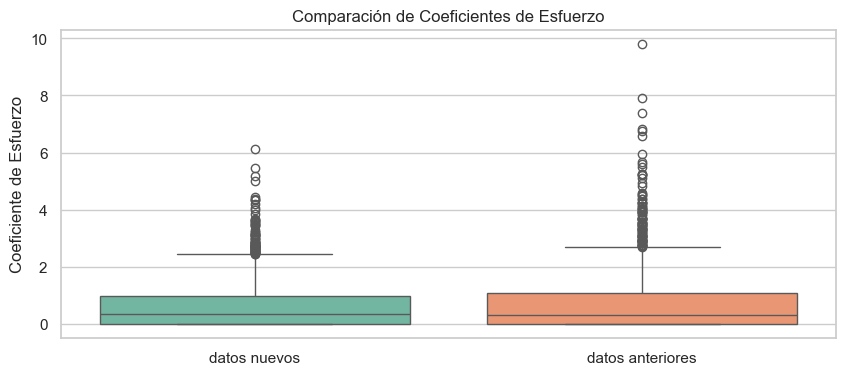

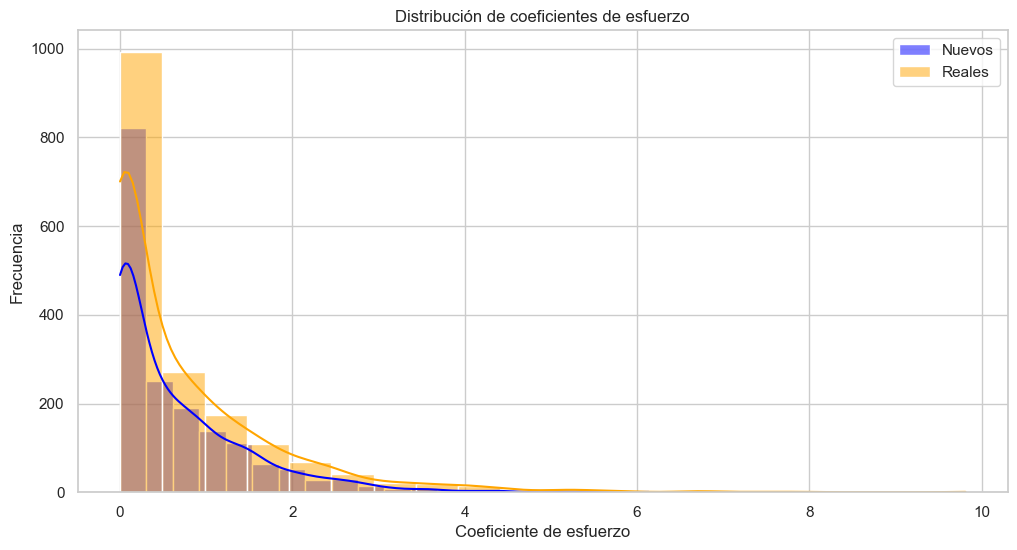

In [36]:
# Verificar similitud entre las caracterzaciones con Prueba de Mann-Whitney U

from scipy.stats import mannwhitneyu

#DataFrame 'comparacion' de tu código anterior

# Extraer los coeficientes de esfuerzo
coeficientes_sinteticos = comparacion['coeficiente_esfuerzo_sinteticos']
coeficientes_reales = comparacion['coeficiente_esfuerzo_real']

# Prueba de Mann-Whitney U
stat, p_value = mannwhitneyu(coeficientes_sinteticos, coeficientes_reales)
alpha = 0.05  # Nivel de significancia

print(f'Estadística U de Mann-Whitney: {stat}')
print(f'Valor p: {p_value}')

# Interpretar el resultado
if p_value < alpha:
    print("Se rechaza la hipótesis nula: los coeficientes de esfuerzo son diferentes entre los grupos.")
else:
    print("No hay suficiente evidencia para decir que los coeficientes de esfuerzo son diferentes entre los grupos.")

# Visualización de los coeficientes
plt.figure(figsize=(10, 4))

# Gráfico de caja para comparar distribuciones
sns.boxplot(data=comparacion[['coeficiente_esfuerzo_sinteticos', 'coeficiente_esfuerzo_real']], palette='Set2')
plt.title('Comparación de Coeficientes de Esfuerzo')
plt.ylabel('Coeficiente de Esfuerzo')
plt.xticks([0, 1], ['datos nuevos', 'datos anteriores'])
plt.show()

# Histograma para una comparación visual más detallada
plt.figure(figsize=(12, 6))
sns.histplot(coeficientes_sinteticos, bins=20, color='blue', alpha=0.5, label='Nuevos', kde=True)
sns.histplot(coeficientes_reales, bins=20, color='orange', alpha=0.5, label='Reales', kde=True)
plt.title('Distribución de coeficientes de esfuerzo')
plt.xlabel('Coeficiente de esfuerzo')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()


In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# DataFrame 'comparacion' de tu código anterior

# Extraer los coeficientes de esfuerzo
coeficientes_sinteticos = comparacion['coeficiente_esfuerzo_sinteticos']
coeficientes_reales = comparacion['coeficiente_esfuerzo_real']

# Prueba de Mann-Whitney U
stat, p_value = mannwhitneyu(coeficientes_sinteticos, coeficientes_reales)
alpha = 0.05  # Nivel de significancia

print(f'Estadística U de Mann-Whitney: {stat}')
print(f'Valor p: {p_value}')

# Interpretar el resultado
if p_value < alpha:
    print("Se rechaza la hipótesis nula: los coeficientes de esfuerzo son diferentes entre los grupos.")
else:
    print("No hay suficiente evidencia para decir que los coeficientes de esfuerzo son diferentes entre los grupos.")

# Visualización de los coeficientes
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Crear 1 fila y 2 columnas

# Gráfico de caja para comparar distribuciones
sns.boxplot(data=comparacion[['coeficiente_esfuerzo_sinteticos', 'coeficiente_esfuerzo_real']], palette='Set2', ax=axes[0])
axes[0].set_title('Comparación de Coeficientes de Esfuerzo', fontsize=12)
axes[0].set_ylabel('Coeficiente de Esfuerzo', fontsize=10)
axes[0].set_xticks([0, 1])  # Establecer ticks
axes[0].set_xticklabels(['Datos Nuevos', 'Datos Anteriores'], fontsize=9)  # Establecer etiquetas de ticks

# Histograma para una comparación visual más detallada
sns.histplot(coeficientes_sinteticos, bins=20, color='blue', alpha=0.5, label='Nuevos', kde=True, ax=axes[1])
sns.histplot(coeficientes_reales, bins=20, color='orange', alpha=0.5, label='Reales', kde=True, ax=axes[1])
axes[1].set_title('Distribución de Coeficientes de Esfuerzo', fontsize=12)
axes[1].set_xlabel('Coeficiente de Esfuerzo', fontsize=10)
axes[1].set_ylabel('Frecuencia', fontsize=10)
axes[1].legend(fontsize=9)

# Ajustar el espacio entre las gráficas
plt.tight_layout()

# Mostrar las gráficas
plt.show()


KeyError: 'coeficiente_esfuerzo_sinteticos'

In [34]:
comparacion.describe()

,coeficiente_esfuerzo_sinteticos,coeficiente_esfuerzo_real
count,"1.731,00","1.731,00"
mean,"0,65","0,73"
std,"0,82","1,05"
min,"0,00","0,00"
25%,"0,00","0,00"
50%,"0,35","0,31"
75%,"0,98","1,07"
max,"6,14","9,81"


In [35]:
df_new.shape

(5040, 37)